In [ ]:
!pip install -U pyartemis==0.1.5 pyALE==1.2.0 -q;
# пакет https://github.com/pyartemis/artemis/blob/master/test/test_pdp_calculator.py
# ALE https://github.com/monte-flora/scikit-explain/tree/master

In [ ]:
!pip install seaborn==0.12.1 matplotlib==3.7.3
#import seaborn as sns
#sns.__version__

## **Взимодействие признаков на мандаринках**

Привет, друзья! Эта практика была подготовлена в Новый год. В ней мы будем работать с датасетом о мандаринках и посмотрим на признаки этого чудного цитруса со всех сторон!

P.S Надеюсь, аллергии на мандарины у вас нет!
Приятного кодинга! 🤗

### **Постановка задачи**
Рассмотрим решение задачи прогнозирования качества мандаринов. С точки зрения постановки, качество есть непрерывная переменная в диапазоне от 0 до 5. Промежуточные значения: `1.5, ..., 4.5` также значимы, а представленные в датасете точки оценки, хоть и дискретны с шагом 0.5, но несбалансированы. Поэтому пробуем решить задачу регрессии.

In [ ]:
import pandas as pd
import numpy as np
from PyALE import ale

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from shap import TreeExplainer

from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from sklearn.tree import plot_tree


LINK = 'https://github.com/aiedu-courses/all_datasets/raw/main/orange_dataset.csv'
data = pd.read_csv(LINK, index_col=0)

### **Построение модели**

В ячейке ниже мы просто обучим модель, используя `MinMaxScaler`. Преобразование (масштабирование), осуществляется так:

1. Определяем желаемый диапазон признаков — обычно $(0, 1)$. Обозначим $x_{min} = 0, x_{max} = 1$:

2. Масштабируем данные по формуле:

$$X_{scaled} = \frac{X-min(X)}{max(X) - min(X)}*(x_{max} - x_{min} + x_{min})$$

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Подготовка датасета к обучению
X = data.drop('Quality (1-5)', axis=1)
y = data['Quality (1-5)']

feature_names = list(data.columns)
feature_names.remove('Quality (1-5)')

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Масштабирование
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train, columns = feature_names)
X_test = pd.DataFrame(X_test, columns = feature_names)

В качестве модели будем использовать решающее дерево.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Обучение модели
tree = DecisionTreeRegressor(random_state=42, max_depth=4)
tree.fit(X_train, y_train)

#predictions = np.clip(tree.predict(X_test), 1, 5)
predictions = tree.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Model MSE : {mse}, rmse: {mse**(1/2)}')

**Примечание:** Мы могли бы сжимать прогноз, чтобы не выходить за диапазоны. Но дерево, по построению, не будет выходить за диапазон, на котором оно было обучено.

**Задание 1.**

Сделайте прогноз на тестовых данных `X_test`. Какое максимальное значение прогноза?

Ответ округлите до сотых.

In [ ]:
# Ваш код здесь

### **Построение карт значимости**

Давайте выберем пару признаков для анализа, исходя из их смысла в задаче. Среди признаков, у нас есть:

- `Size (cm)` — размер мандарина в сантиметрах.  
- `Weight (g)` — вес мандарина в граммах.  
- `Brix (Sweetness)` — показатель сладости мандарина
- `pH (Acidity)` — уровень кислотности мандарина.  
- `Softness (1-5)` — мягкость мандарина по шкале от 1 (очень твердый) до 5 (очень мягкий).  
- `HarvestTime (days)` — время сбора урожая, указанное в днях с момента начала сезона.  
- `Ripeness (1-5)` — степень зрелости мандарина по шкале от 1 (незрелый) до 5 (полностью зрелый).  
- `Blemishes (Y/N)` — наличие повреждений или дефектов на кожуре мандарина (Y — есть, N — нет).  
- `Color_Light Orange` — цвет мандарина: светло-оранжевый.  
- `Color_Orange` — цвет мандарина: оранжевый.  
- `Color_Orange-Red` — цвет мандарина: оранжево-красный.  
- `Color_Yellow-Orange` — цвет мандарина: желто-оранжевый.  

**Задание 2.**

Сколько в данных бинарных признаков?

`Ваш ответ здесь.`

### **Сладость и кислотность**
Выберем признаки для анализа. Давайте посмотрим, как влияют сладость `Brix (Sweetness)` и кислотность `pH (Acidity)` на прогноз. Для начала посмотрим одномерное влияние при помощи **PDP** и **ALE** графиков.

In [ ]:
feature_idx = 2
feature_name = data.columns[feature_idx]

print(f'Анализируем {feature_name}')

Анализируем Brix (Sweetness)


In [ ]:
results = partial_dependence(tree, X_test, [feature_idx], grid_resolution=20, kind='average')
#results = partial_dependence(tree, X_test, [0], grid_resolution=20, kind='individual') == ICE

results
plt.plot(results['grid_values'][0], results['average'][0])

plt.title(f'PDP plot for {feature_name}')
plt.xlabel(f'{feature_name} value')
plt.ylabel('model prediction');

Видно, что есть некоторый порог сладости, после которого модель склонна присваивать мандарину лучшее качество. А что до кислотности?

**Задание 3.**
Постройте одномерный график для кислотности и сделайте вывод о характере влияния.


In [ ]:
feature_idx = # Ваш код здесь
feature_name = # Ваш код здесь

print(f'Анализируем {feature_name}')

Анализируем pH (Acidity)


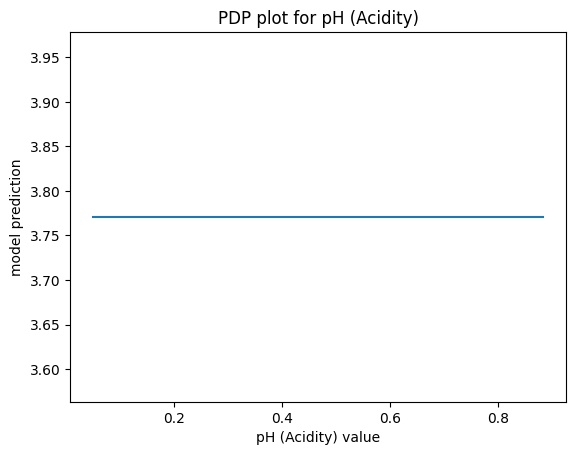

In [ ]:
# Ваш код здесь

results =

plt.plot(results['grid_values'][0], results['average'][0])

plt.title(f'PDP plot for {feature_name}')
plt.xlabel(f'{feature_name} value')
plt.ylabel('model prediction');

Если мы рассмотрим ALE, то зависимости будет похожа. Можете убедиться в этом, построив ALE для ph сами.

In [ ]:
brix = 'Brix (Sweetness)'
ph = 'pH (Acidity)'

ale_eff = ale(
    X=pd.DataFrame(X_test, columns=feature_names), model=tree, feature=[brix], grid_size=50, include_CI=True
)

In [ ]:
# Ваш код здесь

### **Оценка двумерного влияния**

Перейдем к оценке признаков в паре. Посмотрим на совместное влияние `Brix (Sweetness)` и `pH (Acidity)` двумя способами.

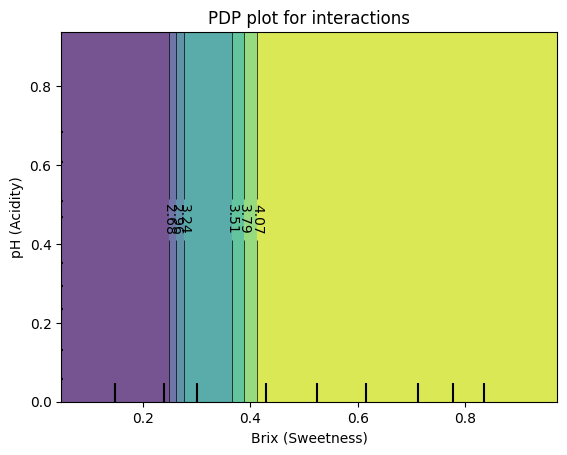

In [ ]:
# Построим pdp график
PartialDependenceDisplay.from_estimator(tree, X_test, [(2, 3)])
plt.title('PDP plot for interactions');

**Задание 4.**
Проанализируйте график выше. Аналогично, постройте двумерный график для `Brix` в паре с признаками `Size, Weight, Harvest Time`.  

Гипотезу о совместном влиянии `Brix` с каким из признаков можно выдвинуть?

In [ ]:
# Ваш код здесь

`Ваш ответ здесь.`

**Задание 5.**

Для признака из задания 4 постройте ALE. Что происходит с совместным эффектом, если поправить его на интервалы?

In [ ]:
# подсказка: используйте impute_empty_cells

# Ваш код здесь


### **SHAP**

Получение interaction values в shap повторяет шаги построения данного метода анализа вклада признаков, для случая, когда мы вычисляем индивидуальный вклад.

In [ ]:
pred = tree.predict(X_test)

explainer = TreeExplainer(tree)
explanation = explainer(X_test)

**Задание 6.**

С помощью атрибутов explainer вытащите interaction values. Вам поможет `dir(explainer)`. Атрибут в названии содержит слово `interaction` и не имеет нижних подчеркиваний. Сколько размерностей у полученного объъекта?

In [ ]:
# Ваш код здесь

Сравните это с размерностью `X_test`. Парное взаимодействие содержится для каждого объекта в данных.

Проанализируем парное взаимодействие для одного объекта. Зафикисруем объект с индексом 0 и посмотрим парные эффекты для него.

In [ ]:
pd.DataFrame(shap_interaction[0],index=feature_names,columns=feature_names)

**Задание 7.** Вместе с каким признаком по типу (кроме самого себя) `Brix` оказывает наиболее сильное взаимодействие для объекта с индексом 0?

`Ваш ответ здесь`

In [ ]:
#Рассчитаем базовое значение (средний прогноз)
mean_pred = np.mean(pred)

sum_shap = np.sum(shap_interaction[0])

print(f"Прогноз модели: {pred[0]}")
print(f"Средний прогноз: {mean_pred}, сумма shap: {sum_shap}")

Прогноз модели: 4.916666666666667
Средний прогноз: 3.7511207786729317, сумма shap: 1.145833333333333


Вот так: сумма всех взаимодействий дает в точности значение, прибавляемое к среднему от прогноза.

Более информативно анализировать взаимодействия для всех сразу, в виде матрицы. Для этого достаточно усреднить полученный выход по объектам (нулевой оси) и построить тепловую карту.

In [ ]:
import seaborn as sns
# Усреднение (можно взять медиану — она более устойчива к "слишком большим" или "слишком маленьким" среди всех значениями — на всякий случай)
mean_shap = np.round(np.median(np.abs(shap_interaction), 0), 4)

df = pd.DataFrame(mean_shap,index=feature_names,columns=feature_names)

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(df, ax=ax, annot=df)

plt.title('SHAP heatmap')
plt.xticks(rotation=45);

**Задание 8.** Вместе с каким признаком (кроме самого себя) `Brix` взаимодействует больше всего в среднем по датасету?

`Ваш ответ здесь.`

### **H-statistic**

Наконец, используем H-статистику. Проверьте, согласуется ли результат с shap?

In [ ]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(tree, X_test)

/usr/local/lib/python3.10/dist-packages/artemis/interactions_methods/model_agnostic/partial_dependence_based/_friedman_h_statistic.py:226: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(nominator) / np.sum(denominator) if normalized else np.sqrt(np.mean(nominator))


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

h_stat.plot(figsize=(20, 10), ax=ax);
plt.xticks(rotation=45);

Заметьте, что H-статистика предлагает больше взаимодействий, чем shap. Насколько это правда? Проверять необходимо в модели. На практике значения Шепли более устойчивы.

В качестве упражнения — посмотрите на код ниже и структуру дерева в нем. Полученные нами результаты во многом обусловлены структурой модели и их было бы быстрее найти, вытащив структуру дерева. Однако, в случае более сложных алгоритмов, графики будут себя показывать прекрасным способом избежать анализа сложной структуры. Просто попробуйте перезапустить тетрадь с Random Forest.

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(tree, proportion=True, ax=ax, feature_names=feature_names);